In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import anndata as ad
import scipy
import gget
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# local 
import utils as ut

In [2]:
# load predictions
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/merged_predictions.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

for c in df.columns:
    if not c == 'index':
        df[f'{c}_clean'] = df[c].apply(lambda x: x.split(":")[1]).astype(str)


# load clustering results
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/embedding.csv"
cdf = pd.read_csv(fpath)
print(f"{cdf.shape=}")

# merge 'em'
df = pd.merge(df, cdf, 
              how='left',
              left_on='index',
              right_on='index')


# clean-up the cell type
df = df.set_index('index')


print(f"{df.shape=}")
df.head()

df.shape=(43312, 5)
cdf.shape=(43312, 3)
df.shape=(43312, 10)


,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,UMAP2
index,,,,,,,,,,
AAACCCACATGGCTGC-1_fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,14.083050
AAACCCAGTATATGGA-1_fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,2.956433
AAACCCAGTCAACACT-1_fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,-6.143299
AAACCCATCCCGTGAG-1_fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,14.408034
AAACCCATCGAACTCA-1_fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,7.478702


In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/h5ad_files/"

data = {}

for f in os.listdir(dirpath):
    fullpath = f"{dirpath}{f}"
    key = f.replace(".h5ad", "")

    batch_andata = sc.read(fullpath)
    batch_andata.obs['batch'] = key
    data[key] = batch_andata
    
adata = ad.concat(data, index_unique="_") # combine all the experiments
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 43312 × 32285
    obs: 'batch'

In [4]:
# add the metadata into the object
adata.obs = adata.obs.join(df, 
                           how='left')

adata.obs['Diet'] = adata.obs['batch'].apply(lambda x: x.split("_")[0])
adata.obs['Sex'] = adata.obs['batch'].apply(lambda x: x.split("_")[1])

adata.obsm['X_umap'] = adata.obs[['UMAP1', 'UMAP2']].copy().to_numpy()

adata.obs.head()

,batch,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,UMAP2,Diet,Sex
AAACCCACATGGCTGC-1_fasted_m,fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,14.083050,fasted,m
AAACCCAGTATATGGA-1_fasted_m,fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,2.956433,fasted,m
AAACCCAGTCAACACT-1_fasted_m,fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,-6.143299,fasted,m
AAACCCATCCCGTGAG-1_fasted_m,fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,14.408034,fasted,m
AAACCCATCGAACTCA-1_fasted_m,fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,7.478702,fasted,m


In [5]:
"""some simple processing """

adata.layers["counts"] = adata.X.copy() # store the raw counts

""" Add a metadata column """
adata.obs['broad_type'] = adata.obs['reference_embedding_C25_named_clean'].apply(lambda x: x.split("-")[0])

sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.calculate_qc_metrics(adata)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.combat(adata) # regress out batch effects

sc.pp.highly_variable_genes(adata, 
                            min_mean=0.0125, 
                            max_mean=3, 
                            min_disp=0.5)

sc.tl.pca(adata, n_comps=40)

adata

... storing 'batch' as categorical
... storing 'reference_embedding_C7_named' as categorical
... storing 'reference_embedding_C25_named' as categorical
... storing 'C25_named' as categorical
... storing 'C7_named' as categorical
... storing 'reference_embedding_C7_named_clean' as categorical
... storing 'reference_embedding_C25_named_clean' as categorical
... storing 'C25_named_clean' as categorical
... storing 'C7_named_clean' as categorical
... storing 'Diet' as categorical
... storing 'Sex' as categorical
... storing 'broad_type' as categorical


AnnData object with n_obs × n_vars = 42937 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [6]:
"""A metdata columns for sun1 and mc3r """

mask = np.ravel(adata[:, ['Sun1']].layers['counts'].todense() > 0)
adata.obs['Sun1'] = np.where(mask, 1, 0)
adata.obs['Sun1'] = adata.obs['Sun1'].astype('category')

mask = np.ravel(adata[:, ['Mc3r']].layers['counts'].todense() > 0)
adata.obs['Mc3r'] = np.where(mask, 1, 0)
adata.obs['Mc3r'] = adata.obs['Mc3r'].astype('category')

adata.obs[['Sun1', 'Mc3r']].value_counts()

Sun1  Mc3r
1     0       21212
0     0       20963
1     1         502
0     1         260
dtype: int64

In [7]:
""" Sun1+ vs Sun1- for M3cr Cells """

mc3r = adata[adata.obs["Mc3r"] == 1] 

mc3r.obs[['Diet', 'Sex', 'Sun1']].value_counts()

Diet    Sex  Sun1
fasted  f    1       211
        m    1       151
        f    0       126
fed     f    1        70
        m    1        70
fasted  m    0        58
fed     m    0        39
        f    0        37
dtype: int64

In [8]:
mc3r.obs[['broad_type', 'Sun1']].value_counts()

broad_type          Sun1
 GLU                1       326
 GABA               1       171
 GLU                0       146
 GABA               0        99
 Oligodendrocytes   0         8
 Astrocytes         0         2
                    1         2
 Immune             0         2
 Ependymal          0         1
 Mural+Endothelial  0         1
 OPC                0         1
                    1         1
 Oligodendrocytes   1         1
 ParsTuber          1         1
dtype: int64

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


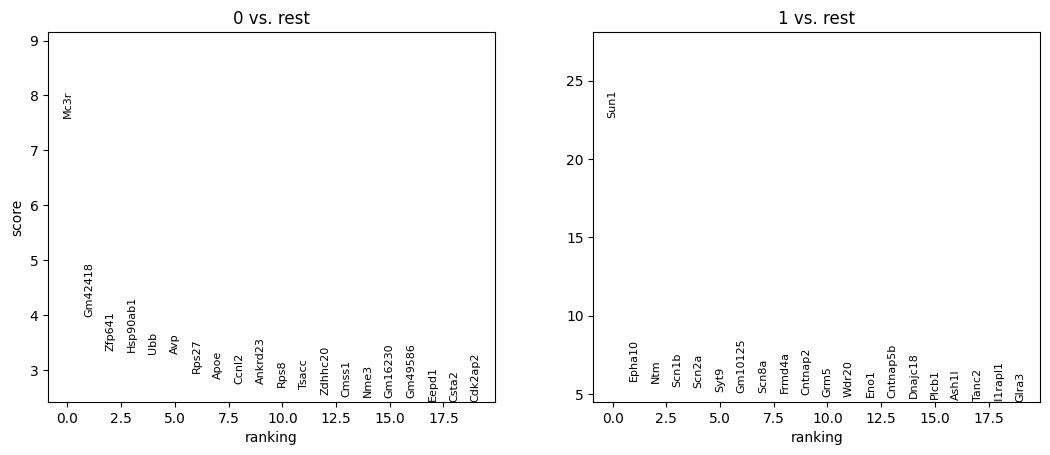

      names  logfoldchanges     pvals_adj
0      Mc3r        0.601196  3.694947e-10
1   Gm42418        0.278961  2.365968e-02
2    Zfp641        0.734302  5.790220e-02
3  Hsp90ab1        0.422428  5.934861e-02
4       Ubb        0.378431  6.171636e-02

        names  logfoldchanges      pvals_adj
25055   Scn2a       -0.529402   2.471579e-04
25056   Scn1b       -0.945437   2.356530e-04
25057     Ntm       -0.845998   7.482270e-05
25058  Epha10       -0.838257   4.043047e-05
25059    Sun1             NaN  3.223141e-109


In [9]:
alpha = 0.05

sc.tl.rank_genes_groups(mc3r, 
                        groupby='Sun1', 
                        method='wilcoxon',
                        key_added='pairwise_batch',
                        corr_method='benjamini-hochberg') 

sc.pl.rank_genes_groups(mc3r, 
                        n_genes=20, 
                        key='pairwise_batch',
                        sharey=False,
                        ncols=2)

deg = sc.get.rank_genes_groups_df(mc3r, 
                                  group='0',
                                  key='pairwise_batch')

deg['log10p'] = -1 * np.log10(deg['pvals'])

# pdf = deg.copy()
# mask = (pdf['logfoldchanges'] > -2) & (pdf['logfoldchanges'] < 2) & (pdf['pvals'] <= alpha)
# pdf = pdf[mask]

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 4, 2.5

# sns.scatterplot(data=pdf, 
#                 x='logfoldchanges',
#                 y='log10p',
#                 ec='none',
#                 alpha=0.6,
#                 color='grey',
#                 zorder=1,
#                 s=5)

# sns.despine()

# plt.gca().set_ylabel(r"-log$_{10}$($p$-value)")
# plt.gca().set_xlabel(r"Fold Change (log$_{2}$)")

# plt.axvline(x=1, lw=1, c='k', ls=':', zorder=3)
# plt.axvline(x=-1, lw=1, c='k', ls=':', zorder=3)


print(deg[['names', 'logfoldchanges', 'pvals_adj']].head())
print()
print(deg[['names', 'logfoldchanges', 'pvals_adj']].tail())

# upregulated genes in Sun1+/M3cr+ vs Sun1-/M3cr+ cells

In [10]:
""" upregulated genes in Sun1+/M3cr+ cells """
query_n = 100
alpha = 0.05
pdf = deg.copy()

pdf = pdf[pdf['pvals_adj'] <= alpha]
pdf = pdf.sort_values(by='logfoldchanges')

genes = pdf.head(query_n)
print(genes.head())

query = genes['names'].to_list()

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

enrich = gget.enrichr(query, database=db)
pd.set_option('display.max_colwidth', 100)
enrich[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

Wed Oct 11 15:24:18 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


               names    scores  logfoldchanges     pvals  pvals_adj    log10p
24926          Hipk4 -3.757836       -1.692256  0.000171   0.031383  3.766016
24971           Kdm8 -3.910398       -1.594992  0.000092   0.025375  4.035533
24876  B630019K06Rik -3.635473       -1.317313  0.000277   0.037384  3.556782
25024          Efhd2 -4.314456       -1.030914  0.000016   0.010837  4.795889
24915         Tbc1d7 -3.726594       -1.024199  0.000194   0.033067  3.712009


,path_name,adj_p_val,overlapping_genes
0,"synaptic transmission, glycinergic (GO:0060012)",0.064713,"[GLRA1, GLRA3]"
1,entrainment of circadian clock by photoperiod (GO:0043153),0.064713,"[PER1, PER3, CRY1]"
2,photoperiodism (GO:0009648),0.064713,"[PER1, PER3, CRY1]"
3,negative regulation of glucocorticoid receptor signaling pathway (GO:2000323),0.064713,"[PER1, CRY1]"
4,regulation of glucocorticoid receptor signaling pathway (GO:2000322),0.064713,"[PER1, CRY1]"
5,axon guidance (GO:0007411),0.064713,"[EPHA10, GPC1, SLIT3, CNTN4, SPTB, SCN1B]"
6,mitochondrial translational elongation (GO:0070125),0.084577,"[MRPS25, MRPL27, ERAL1, CHCHD1]"
7,mitochondrial translational termination (GO:0070126),0.084577,"[MRPS25, MRPL27, ERAL1, CHCHD1]"
8,axonogenesis (GO:0007409),0.084577,"[EPHA10, GPC1, SLIT3, CNTN4, SPTB, SCN1B]"
9,positive regulation of acrosome reaction (GO:2000344),0.084577,"[GLRA1, PLCB1]"


# down-regulated genes in Sun1+/M3cr+ vs Sun1-/M3cr+ cells

In [11]:
""" upregulated genes in Sun1+/M3cr+ cells """
query_n = 100
alpha = 0.05
pdf = deg.copy()

pdf = pdf[pdf['pvals_adj'] <= alpha]
pdf = pdf.sort_values(by='logfoldchanges')

genes = pdf.tail(query_n)
print(genes.head())

query = genes['names'].to_list()

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

enrich = gget.enrichr(query, database=db)
pd.set_option('display.max_colwidth', 100)
enrich[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

Wed Oct 11 15:24:18 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


         names    scores  logfoldchanges     pvals  pvals_adj    log10p
24866     Vapb -3.599719       -0.474996  0.000319   0.040605  3.496807
24956   Atp2b4 -3.824831       -0.474235  0.000131   0.030938  3.883188
24973    Nhsl2 -3.920118       -0.473289  0.000089   0.024751  4.053029
25043    Ash1l -4.657245       -0.471337  0.000003   0.004462  5.494213
24867  Slc35g2 -3.606488       -0.471156  0.000310   0.039886  3.508121


,path_name,adj_p_val,overlapping_genes
0,endoplasmic reticulum localization (GO:0051643),0.104198,"[POLR2M, VAPB]"
1,"regulation of retrograde transport, endosome to Golgi (GO:1905279)",0.104198,"[PRKN, USP7]"
2,protein glycosylation (GO:0006486),0.104198,"[B3GALNT2, GOLGA2, GALNT1, ALG2, FKTN]"
3,regulation of dendrite morphogenesis (GO:0048814),0.104198,"[RAP2A, ADGRB3, HECW1]"
4,regulation of protein glycosylation (GO:0060049),0.104198,"[GOLGA2, FKTN]"
5,excitatory synapse assembly (GO:1904861),0.104198,"[GRID2, NLGN1]"
6,regulation of dendrite development (GO:0050773),0.124779,"[RAP2A, ADGRB3, HECW1]"
7,neuron remodeling (GO:0016322),0.124779,"[ADGRB3, CX3CL1]"
8,cell junction assembly (GO:0034329),0.175684,"[TJP1, NLGN1, TLN2, CDH9]"
9,regulation of cAMP-dependent protein kinase activity (GO:2000479),0.181137,"[PRKAR2A, ATP2B4]"


# GABA Neurons (Sun1+/M3cr+ vs Sun1-/M3cr+ )

In [12]:
gaba = mc3r[mc3r.obs['broad_type'] == " GABA"]

sc.tl.rank_genes_groups(gaba, 
                        groupby='Sun1', 
                        method='wilcoxon',
                        key_added='gaba',
                        corr_method='benjamini-hochberg') 

deg = sc.get.rank_genes_groups_df(gaba, 
                                  group='0',
                                  key='gaba')

deg['log10p'] = -1 * np.log10(deg['pvals'])
print(deg[['names', 'logfoldchanges', 'pvals_adj']].head())
print()
print(deg[['names', 'logfoldchanges', 'pvals_adj']].tail())

/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


   names  logfoldchanges  pvals_adj
0    Avp        1.674882   0.169620
1  Pcbp4        0.672764   0.204603
2  P4ha1        0.673343   0.204603
3   Mc3r        0.430677   0.204603
4  Zc4h2        1.485336   0.204603

          names  logfoldchanges     pvals_adj
25055     Unc5a       -1.463898  7.953429e-02
25056  Il1rapl1       -0.894662  7.175847e-02
25057     Rab6b       -0.955180  4.907012e-02
25058      Grk4       -2.381884  4.907012e-02
25059      Sun1             NaN  2.934724e-38


In [13]:
glu = mc3r[mc3r.obs['broad_type'] == " GLU"]

sc.tl.rank_genes_groups(glu, 
                        groupby='Sun1', 
                        method='wilcoxon',
                        key_added='glu',
                        corr_method='benjamini-hochberg') 

deg = sc.get.rank_genes_groups_df(glu, 
                                  group='0',
                                  key='glu')

deg['log10p'] = -1 * np.log10(deg['pvals'])
print(deg[['names', 'logfoldchanges', 'pvals_adj']].head())
print()
print(deg[['names', 'logfoldchanges', 'pvals_adj']].tail())

/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


    names  logfoldchanges  pvals_adj
0    Mc3r        0.494314   0.000012
1   Rps27        0.535405   0.579974
2   Ywhah        0.727120   0.602697
3     Ubb        0.404698   0.625339
4  Prrc2c        0.201024   0.625339

       names  logfoldchanges     pvals_adj
25055  Atg2b       -0.966706  1.094278e-01
25056   Eno1       -1.101345  6.625874e-02
25057   Mdh2       -0.976551  6.625874e-02
25058  Exoc4       -0.472451  2.201248e-02
25059   Sun1             NaN  3.219134e-63


In [14]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Slc1a2',
    'Slc7a10',
    'Slc39a12',
    'Itih3',
    'Gad1',
    'Gad2',
    'Gabbr2',
    'Grin2b',
    'Slc17a6',
    'Aim2',
    'P2rx7',
    'Il10ra',
    'Ninj2',
    'Sec14l5', 
    'Drd2', 
    'Mest',
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
pdf.head()

In [ ]:
res = []

for ctype, group in pdf.groupby('C7_named_clean'):
    mask = (group['sun1'] == 1)
    p = group[mask].reset_index(drop=False)
    n = group[~mask].reset_index(drop=False)

    # print(f"{ctype} {p.shape=} {n.shape=}")

    ex = pd.concat([p[query].mean(), n[query].mean()], axis=1)
    ex.columns = ['positive', 'negative']

    
    ex['ctype'] = ctype
    ex = ex.reset_index(drop=False)

    ex['logfoldchange'] = ex[['positive', 'negative']].apply(lambda x: np.log1p(x[0]) - np.log1p(x[1]), axis=1)

    res.append(ex)
    # break

res = pd.concat(res)
res = pd.melt(res, id_vars=['ctype', 'index'], value_vars='logfoldchange')
res.head()

In [ ]:
pdf = pd.pivot_table(res, index='index', columns='ctype',
                 values='value')

pdf = np.abs(pdf)
print(pdf.max())

sns.heatmap(pdf.T,
            cmap='coolwarm',
            lw=1,
            cbar=False,
            square=True)

plt.ylabel("")
plt.xlabel("")

In [ ]:
# ut.makeColorbar('coolwarm', 0.2, 3, "Abs. Fold Change (log)", 'vertical', ['0', '0.5'])

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Mc3r', 
    "Agrp", 
    "Npy", 
    "Nr5a1", 
    "Pomc", 
    "Mc4r", 
    "Gnrhr", 
    "Gnrh1", 
    "Ghrh", 
    "Ghrhr", 
    "Sst", 
    "Esr1",
    "Lepr",
    "Pnoc",
    "Adcyap1",
    "Foxp2", 
    "Dlk1",
    "Kiss1", 
    "Tac2", 
    "Pdyn", 
    "Rprm",
    "Oxtr",
    "Drd2",
    "Gria3", 
    "Grik1", 
    "Grik3", 
    "Gabra5", 
    "Gabra2", 
    "Syndig1",
    "Pak3",
    "Ptk2b", 
    "Plk2",
    "Trh",
    "Glp1r",
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
res = []

for ctype, group in pdf.groupby('C25_named_clean'):
    mask = (group['sun1'] == 1)
    p = group[mask].reset_index(drop=False)
    n = group[~mask].reset_index(drop=False)

    # print(f"{ctype} {p.shape=} {n.shape=}")

    ex = pd.concat([p[query].mean(), n[query].mean()], axis=1)
    ex.columns = ['positive', 'negative']

    
    ex['ctype'] = ctype
    ex = ex.reset_index(drop=False)

    ex['logfoldchange'] = ex[['positive', 'negative']].apply(lambda x: np.log1p(x[0]) - np.log1p(x[1]), axis=1)

    res.append(ex)
    # break

res = pd.concat(res)
res = pd.melt(res, id_vars=['ctype', 'index'], value_vars='logfoldchange')
res.head()

In [ ]:
pdf = pd.pivot_table(res, index='index', columns='ctype',
                 values='value')

pdf = np.abs(pdf)
print(pdf.max())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 10

sns.heatmap(pdf,
            cmap='coolwarm',
            lw=0.5,
            cbar=False,
            square=True)

plt.ylabel("")
plt.xlabel("")

In [ ]:
break

In [ ]:
"""Randomly sampled genes """

sample_n = 5000
query = np.random.choice(adata.var_names, sample_n, replace=False)

"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
res = []

allcount = 0
for ctype, group in pdf.groupby('C7_named_clean'):
    print(f"working... {ctype}")
    mask = (group['sun1'] == 1)
    p = group[mask].reset_index(drop=False)
    n = group[~mask].reset_index(drop=False)
    allcount += p.shape[0]

    for g in query:

        score, pval = scipy.stats.ranksums(p[g], n[g])
        # score, pval = scipy.stats.ttest_ind(p[g], n[g])

        pos_mean = p[g].mean()
        neg_mean = n[g].mean()
        lfc = np.log2(pos_mean + 1) - np.log2(neg_mean + 1)
        
        row = {
            'celltype' : ctype,
            'gene' : g,
            'score' : score, 
            'pval' : pval,
            'log2foldchange' : lfc,
            'sun1_pos_mean' : pos_mean,
            'sun1_neg_mean' : neg_mean,
            'sun1_pos_std' : p[g].std(),
            'sun1_neg_std' : n[g].std(),
            'sun1_pos_n' : len(p[g]),
            'sun1_neg_n' : len(n[g]),
            # 'sun1_pos_reads' : adata[p.index.to_list(), [g]].layers['counts'].sum(),
            # 'sun1_neg_reads' : adata[n.index.to_list(), [g]].layers['counts'].sum(),
        }
        res.append(row)

        
res = pd.DataFrame(res)
res.head()
# allcount

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

sns.histplot(data=res, 
             x='pval',
             bins=100,
             kde=True,)
             # hue='celltype',
             # log_scale=True)

sns.despine()
# sns.move_legend(plt.gca(), 
#                 title="",
#                 frameon=False,
#                 loc='upper right',
#                 bbox_to_anchor=(1.6, 1))

plt.xlim([0.0, 1.1])
plt.xlabel(r"$p$-value")


In [ ]:
pdf = res.copy()
pdf = pdf.sort_values(by='celltype')
neuro = [' GABA', ' GLU']
pdf = pdf[pdf['celltype'].isin(neuro)]

pdf['log10p'] = -1 * np.log10(pdf['pval'])


sns.scatterplot(data=pdf, 
                x='log2foldchange',
                y='log10p',
                ec='none',
                color='grey',
                s=2,
                alpha=0.5)

pdf.head()
sns.despine()

In [ ]:
pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

n_query = 500
ascending = False # false means highest upregulated  in sun1+

alpha = 0.05
ntests = len(pdf)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alphaHat}")

pdf = pdf[pdf['pval'] <= alphaHat]
print(pdf['celltype'].value_counts())
print()

neuro = [' GABA', ' GLU']
pdf = pdf[pdf['celltype'].isin(neuro)]

pdf = pdf.sort_values(by='log2foldchange', ascending=ascending)
print(pdf.head())

query_genes = list(pdf['gene'].head(n_query).unique())

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05

edf = gget.enrichr(query_genes, database=db)
edf = edf[edf['adj_p_val'] <= e_alpha]
pd.set_option('display.max_colwidth', 150)

# outpath = "GABA_GLU_Sun1_positive_downregulated_genes.csv"
# edf.to_csv(outpath, index=False)

edf[['path_name', 'adj_p_val', 'overlapping_genes']]

In [ ]:
outpath = "GABA_GLU_Sun1_positive_DEG.csv"
pdf.to_csv(outpath, index=False)
pdf = pdf.sort_values(by='log2foldchange', ascending=ascending)
pdf.head(50)

In [ ]:
# pdf = res.copy()
# pdf = pdf.sort_values(by='celltype')

# alpha = 0.05
# ntests = len(pdf)
# alphaHat = 1 - ((1-alpha) ** (1/ntests))
# print(f"{alphaHat}")

# pdf = pdf[pdf['pval'] <= alphaHat]
# print(pdf['celltype'].value_counts())
# print()

# new_query = pdf[pdf['celltype'] == ' GABA']
# new_query


In [ ]:
# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05

edf = gget.enrichr(list(new_query['gene'].unique()), database=db)
edf = edf[edf['adj_p_val'] <= e_alpha]
pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']]

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

sns.kdeplot(data=res, 
             x='pval',
             # bins=500,
             # kde=True,
             palette='nipy_spectral',
             hue='celltype',)
             # log_scale=True)

sns.despine()
sns.move_legend(plt.gca(), 
                title="",
                frameon=False,
                loc='upper right',
                bbox_to_anchor=(1.6, 1))

plt.xlim([0.0, 0.05])



In [ ]:
pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

alpha_threshold = 

pdf.head()

In [ ]:
# p = pd.pivot_table(pdf, index=['C7_named_clean', 'Diet', 'Sex', 'Sun1'], 
#                     columns=query, 
#                     values=query,
#                     aggfunc='mean').reset_index(drop=False)

# print(f"{p.shape=}")
# print(p.head())

In [ ]:
break

In [ ]:
break

In [ ]:
gene = 'Sun1'
mask = (adata[:, [gene]].layers['counts'].todense() > 0)
gene_pos = adata.obs[mask]
print(f"{gene_pos.shape=}")
counts = gene_pos['broad_type'].value_counts().reset_index()

counts = counts.sort_values(by='index')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

total_counts = adata.obs['broad_type'].value_counts().reset_index()
total_counts = total_counts.sort_values(by='index')

sns.barplot(data=total_counts, 
            y='index',
            x='broad_type',
            palette='nipy_spectral',
            ec='k',
            )

ax = plt.gca()

plt.ylabel("")
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("right", size="100%", pad="10%")

sns.barplot(data=counts, 
            y='index',
            x='broad_type',
            palette='nipy_spectral',
            ec='k')

ax2.set_ylabel("")
ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.set_xlabel("n Cells")
ax.set_xlabel("n Cells")

ax.set_title("All Cells")
ax2.set_title("Mc3r+ Cells")

ax2.set_xscale('log')
ax.set_xscale('log')

print(counts)

sns.despine()

In [ ]:
break

In [ ]:
break